<a href="https://colab.research.google.com/github/shizoda/education/blob/main/machine_learning/transformer/Word2Vec_BERT_GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 GPTはどのようにテキストを生成するのか？

この課題では、ChatGPT で使われている「GPT（Generative Pre-trained Transformer）」が、どのようにして自然な文章を作り出すのか、その基本的な仕組みを4つのステップで学んでいきます。

**この課題のゴール:**
-  単語の意味を数値で表現する「埋め込みベクトル」を理解する。
-  多くの単語の意味を重み付けした「文脈ベクトル」を理解する。
-  BERT と GPT の違いを理解する。
-  GPTが「次の単語」をどうやって予測しているか理解する。


In [ ]:
#@title 【まず実行】必要なライブラリのインストール
# Transformers ライブラリ（BERTやGPTを使うためのもの）
# tqdm は進捗バーを表示するため
!pip install -q transformers torch tqdm gensim
print("✅ ライブラリのインストールが完了しました。")

#@title GPUの確認
import torch
import tqdm # tqdm のインポート（永続的指示）

# GPUが利用可能か確認し、デバイスを設定します
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"利用中のデバイス: {device}")


import gensim.downloader as api
from gensim.models import KeyedVectors
import sys
from tqdm.auto import tqdm

# モデル名
model_name = "glove-wiki-gigaword-50"

try:
    # グローバル変数としてモデルをロード
    # (もし 'model_wv' が未定義の場合のみロード)
    if 'model_wv' not in globals():
        print(f"軽量モデル '{model_name}' をダウンロード・ロードしています...")
        print("（初回はダウンロードに時間がかかる場合があります）")

        # gensim.downloader を使ってロード
        # KeyedVectors オブジェクトが返る
        model_wv = api.load(model_name)

        print("\n✅ GloVeモデルのロードが完了しました。")
        print(f"  - 次元数: {model_wv.vector_size}")
        print(f"  - 語彙数: {len(model_wv.key_to_index)}")

except Exception as e:
    print(f"エラー: モデルのロードに失敗しました。{e}", file=sys.stderr)

# 📚 ステップ 0: Word2Vec — 「意味」の計算とその学習方法

GPTやBERTといったAIが登場する前に活躍した「Word2Vec（ワード・トゥ・ベック）」という技術があります。これは、単語を「意味」を持つベクトル（数値のリスト）に変換する技術です。

このステップでは、まずWord2Vecが**どのようにしてそのベクトルを学習するのか**（CBOWモデル）を見てから、その結果として**なぜ「意味の計算」が可能になるのか**を学びます。

---

## 🤔 どうやってベクトルを学習するのか？

Word2Vecは、AIに「**あるタスク**」を解かせることで、副産物として単語のベクトルを獲得します。

### 🧠 1. 中核理論: 分布仮説

Word2Vecの根底には「**分布仮説**」という考え方があります。

> **分布仮説**: ある単語の意味は、その単語の「**周囲に出現する単語**」によって決まる。

例えば、「銀行」という単語は、「お金」「預金」「引き出す」「ローン」といった単語の近くで使われることが多いです。

### 📖 2. 学習タスク (CBOWモデル)

この仮説を実現するため、AI（シンプルなニューラルネットワーク）に「**予測タスク**」を解かせます。代表的なモデルが **CBOW (Continuous Bag-of-Words)** です。

* **CBOWのタスク**: **「周囲の単語」から「中心の単語」を予測（穴埋め）する。**
* **例文**: `... went to the [ ? ] to deposit money`

AIは、この文脈（`deposit`, `money` など）を入力として受け取り、中心の `[ ? ]` が `bank` であることを予測するように学習します。

### 🛠️ 3. 埋め込みベクトルが作られる仕組み

CBOWタスクを解くニューラルネットワークは、以下の仕組みで動作します。

1.  **辞書（埋め込み層 $W_{in}$）**:
    まず、全単語（例: 5万語）分の「辞書テーブル」（$W_{in}$）を用意します。この時点では、各単語のベクトル（例: 50次元）はランダムな数値です。
2.  **入力と平均化**:
    「周囲の単語」（`to`, `the`, `to`, `deposit`など）のベクトルを $W_{in}$ から引き出し、それらを**平均**します。この平均ベクトルが「文脈」を表します。
    （数式: $\mathbf{\hat{v}} = \frac{1}{2m} \sum \mathbf{v}_{context}$）
3.  **予測**:
    この平均文脈ベクトル $\mathbf{\hat{v}}$ を、もう一つの重み行列 $W_{out}$（出力層）に入力し、中心の単語 `[ ? ]` が辞書のどの単語であるかの確率を予測します。
4.  **辞書の更新**:
    「正解は `bank` だった」とAIに教え、予測が正解に近づくようにネットワークを更新します。この時、**$W_{in}$（入力辞書）と $W_{out}$（出力辞書）の両方が、誤差逆伝播によって少しだけ修正されます。**
5.  **繰り返し**:
    この「予測→更新」を、大量のテキスト全体で何億回も繰り返します。

学習が完了すると、$W_{in}$（入力辞書）には、文脈予測タスクを解くために最適化されたベクトル群が残ります。私たちが「単語の埋め込みベクトル」として使うのは、主にこの $W_{in}$ です。

以下の図は、このCBOWモデルの学習の模式図です。

In [20]:
#@title 🤖 (SVG修正版 v7) Word2Vec (CBOW) の学習模式図
from IPython.display import display, HTML

# CBOWモデルの学習プロセスを示すSVG
# 誤差逆伝播の破線を、曲線(Q)から直線(L)に変更
# 矢印が(4)と(2)のブロックの下部中央に上向きで入るように修正
svg_cbow_string = """
<svg width="900px" viewBox="0 0 850 450" xmlns="http://www.w3.org/2000/svg" font-family="Arial, sans-serif">

    <defs>
        <marker id="arrowhead" markerWidth="10" markerHeight="7" refX="0" refY="3.5" orient="auto">
            <polygon points="0 0, 10 3.5, 0 7" fill="#333"/>
        </marker>
        <marker id="arrowhead-red-up" markerWidth="7" markerHeight="10"
                refX="3.5" refY="10" orient="auto" markerUnits="strokeWidth">
            <polygon points="0 10, 3.5 0, 7 10" fill="#D32F2F"/>
        </marker>
    </defs>
    <text x="425" y="30" font-size="24" font-weight="bold" text-anchor="middle" fill="#333">
        Word2Vec (CBOWモデル) の学習の仕組み
    </text>
    <text x="425" y="55" font-size="16" text-anchor="middle" fill="#555">
        タスク: 「周囲の単語」から「中心の単語」を予測する
    </text>

    <g id="input-sentence">
        <text x="180" y="100" font-size="16" text-anchor="middle" fill="#666">入力文の例:</text>
        <rect x="250" y="80" width="50" height="35" rx="5" fill="#F0F0F0" stroke="#AAA"/>
        <text x="275" y="102" font-size="14" text-anchor="middle" fill="#333">to</text>
        <rect x="310" y="80" width="50" height="35" rx="5" fill="#F0F0F0" stroke="#AAA"/>
        <text x="335" y="102" font-size="14" text-anchor="middle" fill="#333">the</text>

        <rect x="370" y="80" width="50" height="35" rx="5" fill="#FF6B6B" stroke="#D32F2F" stroke-width="2"/>
        <text x="395" y="102" font-size="16" font-weight="bold" text-anchor="middle" fill="#FFF">[ ? ]</text>

        <rect x="430" y="80" width="50" height="35" rx="5" fill="#F0F0F0" stroke="#AAA"/>
        <text x="455" y="102" font-size="14" text-anchor="middle" fill="#333">to</text>
        <rect x="490" y="80" width="65" height="35" rx="5" fill="#F0F0F0" stroke="#AAA"/>
        <text x="522.5" y="102" font-size="14" text-anchor="middle" fill="#333">deposit</text>
        <text x="595" y="102" font-size="14" text-anchor="middle" fill="#333">...</text>
    </g>

    <g id="step1-input">
        <text x="100" y="150" font-size="16" font-weight="bold" text-anchor="middle">1. 入力 (文脈語)</text>
        <rect x="60" y="170" width="80" height="30" rx="5" fill="#E3F2FD" stroke="#1976D2"/>
        <text x="100" y="190" font-size="14" text-anchor="middle">"to"</text>
        <rect x="60" y="210" width="80" height="30" rx="5" fill="#E3F2FD" stroke="#1976D2"/>
        <text x="100" y="230" font-size="14" text-anchor="middle">"the"</text>
        <rect x="60" y="250" width="80" height="30" rx="5" fill="#E3F2FD" stroke="#1976D2"/>
        <text x="100" y="270" font-size="14" text-anchor="middle">"to"</text>
        <rect x="60" y="290" width="80" height="30" rx="5" fill="#E3F2FD" stroke="#1976D2"/>
        <text x="100" y="310" font-size="14" text-anchor="middle">"deposit"</text>
    </g>

    <g id="step2-embedding">
        <text x="260" y="150" font-size="16" font-weight="bold" text-anchor="middle">2. 埋め込み層 (辞書)</text>
        <rect x="190" y="170" width="160" height="150" rx="8" fill="#FFF9C4" stroke="#FBC02D"/>

        <text x="270" y="305" font-size="14" text-anchor="middle">
            重み行列 W<tspan baseline-shift="sub" font-size="0.8em">in</tspan>
        </text>

        <text x="200" y="190" font-size="12" fill="#E65100" font-weight="bold">これが学習対象であり、</text>
        <text x="200" y="210" font-size="12" fill="#E65100" font-weight="bold">最終的な「単語ベクトル」</text>
        <text x="200" y="230" font-size="12" fill="#E65100" font-weight="bold">そのものになる。</text>
    </g>

    <path d="M 145 240 L 185 240" fill="none" stroke="#333" stroke-width="2" marker-end="url(#arrowhead)"/>
    <text x="165" y="260" font-size="10" fill="#333" text-anchor="middle">辞書引き</text>

    <g id="step3-average">
        <text x="440" y="150" font-size="16" font-weight="bold" text-anchor="middle">3. 中間層 (平均)</text>
        <rect x="400" y="220" width="80" height="40" rx="20" fill="#E8F5E9" stroke="#388E3C"/>
        <text x="440" y="245" font-size="14" text-anchor="middle">平均化</text>

        <path d="M 355 240 L 395 240" fill="none" stroke="#333" stroke-width="2" marker-end="url(#arrowhead)"/>
        <text x="375" y="225" font-size="10" fill="#333" text-anchor="middle">文脈ベクトル</text>
    </g>

    <g id="step4-output-layer">
        <text x="590" y="150" font-size="16" font-weight="bold" text-anchor="middle">4. 出力層</text>
        <rect x="520" y="170" width="140" height="150" rx="8" fill="#FCE4EC" stroke="#C2185B"/>
        <text x="590" y="305" font-size="14" text-anchor="middle">
            重み行列 W<tspan baseline-shift="sub" font-size="0.8em">out</tspan>
        </text>

        <path d="M 485 240 L 515 240" fill="none" stroke="#333" stroke-width="2" marker-end="url(#arrowhead)"/>
    </g>

    <g id="step5-softmax">
        <text x="750" y="150" font-size="16" font-weight="bold" text-anchor="middle">5. 予測 (Softmax)</text>
        <rect x="700" y="170" width="100" height="150" rx="5" fill="#F3E5F5" stroke="#7B1FA2"/>
        <text x="750" y="190" font-size="12" text-anchor="middle">全語彙の確率</text>
        <text x="750" y="210" font-size="11" text-anchor="middle">"apple": 0.01%</text>
        <text x="750" y="230" font-size="11" text-anchor="middle">"river": 0.03%</text>
        <rect x="705" y="240" width="90" height="20" fill="#C8E6C9" stroke="#2E7D32"/>
        <text x="750" y="254" font-size="12" font-weight="bold" text-anchor="middle">"bank": 92%</text>
        <text x="750" y="275" font-size="11" text-anchor="middle">...</text>

        <path d="M 665 240 L 695 240" fill="none" stroke="#333" stroke-width="2" marker-end="url(#arrowhead)"/>
    </g>

    <g id="update-loop">
        <text x="750" y="340" font-size="14" fill="#4CAF50" text-anchor="middle">正解: "bank"</text>
        <text x="750" y="360" font-size="14" fill="#D32F2F" text-anchor="middle">誤差を計算</text>

        <path d="M 750 360 L 750 390 L 590 390 L 590 325"
              fill="none" stroke="#D32F2F" stroke-width="2" stroke-dasharray="5,5"/>

        <path d="M 750 360 L 750 410 L 270 410 L 270 325"
              fill="none" stroke="#D32F2F" stroke-width="2" stroke-dasharray="5,5""/>

        <text x="425" y="375" font-size="14" font-weight="bold" text-anchor="middle" fill="#D32F2F">
            誤差を逆伝播し、重み
            <tspan x="425" dy="1.2em">
                (W<tspan baseline-shift="sub" font-size="0.8em">in</tspan> と W<tspan baseline-shift="sub" font-size="0.8em">out</tspan>) を更新する
            </tspan>
        </text>
        </g>
</svg>
"""

# HTML() を使って表示します
display(HTML(svg_cbow_string))

## 🧮 学習の結果: 「意味」の計算

この学習の結果、`bank`（銀行）という単語のベクトルは、`deposit`（預金）や `money`（お金）といった単語のベクトルと、「予測タスクを解く上で関連性が高い」と判断され、ベクトル空間上で近い位置に配置されるよう調整されます。

Word2Vecのすごいところは、単なる近さだけでなく、**単語と単語の「関係性」も「方向」として学習する**点にあります。

---

### 🧭 有名な計算式: king - man + woman = queen

Word2Vecの世界で最も有名なのが、この計算式です。

> `(king) - (man) + (woman) ≈ (queen)`

「`king`（王様）」が持つベクトルから「`man`（男性）」っぽさを引き算し、そこに「`woman`（女性）」っぽさを足し算すると、その計算結果は「`queen`（女王）」が持つベクトルと、ほぼ同じ値になります。

なぜなら、Word2Vecは大量の文章を学習することで、
* 「`man`」から「`king`」への「方向」（関係性）
* 「`woman`」から「`queen`」への「方向」（関係性）

これらがどちらも **「（その性別の）王族になる」** という意味の「関係性」であると気づき、この **2つの矢印がほぼ同じ向き・同じ長さ（＝平行）** になるように、各単語の場所（ベクトル）を調整するからです。



### ✨ 重要性

Word2Vecは、大量の文章から **「単語と単語の間の関係性」を自動的に見つけ出し、それを「ベクトル空間上の方向（数値の差分）」として学習** します。

「性別」だけでなく、「国の首都（例: Japan → Tokyo、France → Paris）」や「動詞の時制（例: walk → walked）」といった様々な関係性も、同じように「方向」として数値に保存されます。

この「**意味を位置や方向として捉え、計算できるようにする**」という考え方は、のちのGPTやBERTといった、より複雑なAIが文章の「文脈」を深く理解するための、大切な土台となっています。

（※ただし、先ほどの `bank` の例のように、Word2Vecの段階では「銀行」と「土手」のベクトルは区別できず、混ざり合ってしまいます。この「文脈」の問題はステップ1で見ます。）

## 🧮 計算のステップ（図の解説）

この計算が成り立つ理由を、図を見ながらステップで追ってみましょう。

1.  **「王族の方向」を求める:**
    まず、「`man`」の場所から「`king`」の場所への矢印（図の赤い矢印）を計算します。これが「王族になる」という関係性を表す「方向」です。
    （計算式: `king - man`）

2.  **「`woman`」の場所に足す:**
    次に、この「王族の方向」の矢印を、「`woman`」の場所からスタートさせます。
    （計算式: `woman + (king - man)`）

3.  **着地点は「`queen`」:**
    図が示すように、この地図では関係性（矢印）が平行に保たれているため、「`woman`」の場所から「王族の方向」へ進んだ先には、ちょうど「`queen`」の場所が位置しています。

これが「意味の計算」の正体です。

---

## ✨ 重要性

Word2Vecは、ただ単語を暗記するのではなく、大量の文章から **「単語と単語の間の関係性」を自動的に見つけ出し、それを「地図上の方向（数値の差分）」として学習** します。

「性別」だけでなく、「国の首都（例: Japan → Tokyo、France → Paris）」や「動詞の時制（例: walk → walked）」といった様々な関係性も、同じように「方向」として数値に保存されます。

この「**意味を位置や方向として捉え、計算できるようにする**」という考え方は、のちのGPTやBERTといった、より複雑なAIが文章の「文脈」を深く理解するための、とても大切な土台となっています。

In [ ]:
#@title ベクトル演算 `A - B + C` (計算経路の可視化)

#@markdown ---
#@markdown ### フォーム
#@markdown ベクトル演算 `A - B + C` を実行します。
#@markdown (例: A=king, B=man, C=woman)
wordA = "king" #@param {"type":"string","placeholder":"king"}
wordB = "man" #@param {"type":"string","placeholder":"man"}
wordC = "woman" #@param {"type":"string","placeholder":"woman"}
#@markdown ---
#@markdown ### 可視化オプション
#@markdown 次元削減 (PCA) を用いて、計算結果を2Dプロットします。
#@markdown 上位何件の類似単語をプロットに含めますか？
enable_visualization = True
top_k_to_plot = 7 #@param {type:"slider", min:1, max:20, step:1}
#@markdown ---

import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import sys # エラー表示用

# 0. gensimモデル (model_wv) がロードされているか確認
if 'model_wv' not in globals():
    print("エラー: ステップ0のGloVeモデル (model_wv) がロードされていません。", file=sys.stderr)
    print("（このセルの前の「【実行】GloVeモデルのロード」セルを実行してください。）", file=sys.stderr)
else:
    # 1. 埋め込み行列の取得 (numpy配列)
    embedding_matrix = model_wv.vectors

    print(f"辞書の総単語数: {embedding_matrix.shape[0]}")
    print(f"ベクトルの次元数: {embedding_matrix.shape[1]}") # 50次元のはず

    # 2. 単語のベクトルを取得
    words = [wordA.lower(), wordB.lower(), wordC.lower()]
    vectors = {}
    all_words_found = True

    for word in words:
        if not word: # 空文字列チェック
            print(f"エラー: 単語が入力されていません。", file=sys.stderr)
            all_words_found = False
            break
        try:
            # gensim (KeyedVectors) を使ってベクトルを取得
            vectors[word] = model_wv[word]
            print(f"'{word}' のベクトル取得完了。")

        except KeyError:
            print(f"エラー: 単語 '{word}' がGloVe辞書にありません。", file=sys.stderr)
            all_words_found = False
            break

    # 3. ベクトル演算 (Numpy)
    if all_words_found:
        vecA = vectors[wordA.lower()]
        vecB = vectors[wordB.lower()]
        vecC = vectors[wordC.lower()]

        # ▼▼▼ 要求された全6点のベクトルを計算 ▼▼▼
        vec_A_minus_B = vecA - vecB   # A - B (関係性ベクトル)
        vec_A_plus_C = vecA + vecC    # A + C (中間計算)
        vec_Result = vecA - vecB + vecC # A - B + C (最終結果)

        # 4. 最終結果 (A-B+C) と全単語の類似度を計算
        # gensim の most_similar は positive=[A, C], negative=[B] で
        # この計算 (A-B+C) を内部的に行ってくれます。

        print(f"\n--- 計算結果 (vec({wordA}) - vec({wordB}) + vec({wordC})) に近い単語 Top {top_k_to_plot} ---")

        try:
            similar_words = model_wv.most_similar(
                positive=[wordA.lower(), wordC.lower()],
                negative=[wordB.lower()],
                topn=top_k_to_plot
            )

            # 結果の整形
            results = []
            top_result_labels = [] # 可視化用
            top_result_vectors = [] # 可視化用

            for token_str, similarity in similar_words:
                results.append((token_str, similarity))

                if token_str not in words:
                    top_result_labels.append(token_str)
                    top_result_vectors.append(model_wv[token_str])

            df_results = pd.DataFrame(results, columns=["Word", "Cosine Similarity"])
            print(df_results.to_string(index=False))

        except Exception as e:
            print(f"類似度計算中にエラーが発生しました: {e}", file=sys.stderr)
            enable_visualization = False # 可視化をスキップ

        # --- 6. ▼▼▼ 可視化機能（要求された6点と4矢印） ▼▼▼ ---
        if enable_visualization:
            print("\n--- 2D可視化 (PCA) ---")

            # 1. 収集するベクトルとラベル
            labels_to_plot = [wordA, wordB, wordC]
            vectors_to_plot = [vecA, vecB, vecC]

            labels_to_plot.extend(top_result_labels)
            vectors_to_plot.extend(top_result_vectors)

            # ▼▼▼ A-B, A+C, Result もPCAの対象に含める ▼▼▼
            ab_label = f"{wordA}-{wordB}"
            ac_label = f"{wordA}+{wordC}"
            result_label = f"Result ({wordA}-{wordB}+{wordC})"

            labels_to_plot.extend([ab_label, ac_label, result_label])
            vectors_to_plot.extend([vec_A_minus_B, vec_A_plus_C, vec_Result])

            # 2. Numpy配列に (既にNumpy配列です)
            vectors_np = np.array(vectors_to_plot)

            # 3. PCAで2次元に削減
            pca = PCA(n_components=2)
            vectors_2d = pca.fit_transform(vectors_np)

            # 4. プロット
            plt.figure(figsize=(12, 9))

            # 座標を辞書に
            coords = {label: vectors_2d[i] for i, label in enumerate(labels_to_plot)}

            # A, B, C をプロット
            plt.scatter(coords[wordA][0], coords[wordA][1], c='blue', s=150, label=f"A: {wordA}", zorder=5)
            plt.annotate(wordA, (coords[wordA][0], coords[wordA][1]), fontsize=12, zorder=6)

            plt.scatter(coords[wordB][0], coords[wordB][1], c='red', s=150, label=f"B: {wordB}", zorder=5)
            plt.annotate(wordB, (coords[wordB][0], coords[wordB][1]), fontsize=12, zorder=6)

            plt.scatter(coords[wordC][0], coords[wordC][1], c='green', s=150, label=f"C: {wordC}", zorder=5)
            plt.annotate(wordC, (coords[wordC][0], coords[wordC][1]), fontsize=12, zorder=6)

            # 計算結果 (A-B) をプロット
            plt.scatter(coords[ab_label][0], coords[ab_label][1], c='purple', s=150, marker='X', label=ab_label, zorder=10)
            plt.annotate(ab_label, (coords[ab_label][0], coords[ab_label][1]), fontsize=14, zorder=11)

            # 計算結果 (A+C) をプロット
            plt.scatter(coords[ac_label][0], coords[ac_label][1], c='brown', s=150, marker='X', label=ac_label, zorder=10)
            plt.annotate(ac_label, (coords[ac_label][0], coords[ac_label][1]), fontsize=14, zorder=11)

            # 最終計算結果 (Result) をプロット
            plt.scatter(coords[result_label][0], coords[result_label][1], c='orange', s=300, marker='*', label=result_label, zorder=10)
            plt.annotate(result_label, (coords[result_label][0], coords[result_label][1]), fontsize=14, zorder=11)

            # Top-k の結果をプロット
            for label in top_result_labels:
                plt.scatter(coords[label][0], coords[label][1], c='gray', s=50, alpha=0.7)
                plt.annotate(label, (coords[label][0], coords[label][1]), alpha=0.7)

            # 6. ▼▼▼ 要求された4つの矢印 ▼▼▼

            # 矢印1: A -> A-B (赤色, -B)
            plt.arrow(coords[wordA][0], coords[wordA][1],
                      coords[ab_label][0] - coords[wordA][0],
                      coords[ab_label][1] - coords[wordA][1],
                      color='red', linestyle='--', head_width=0.01, length_includes_head=True, alpha=0.5, label=f"- {wordB}")

            # 矢印2: A -> A+C (緑色, +C)
            plt.arrow(coords[wordA][0], coords[wordA][1],
                      coords[ac_label][0] - coords[wordA][0],
                      coords[ac_label][1] - coords[wordA][1],
                      color='green', linestyle='--', head_width=0.01, length_includes_head=True, alpha=0.5, label=f"+ {wordC}")

            # 矢印3: A+C -> Result (赤色, -B)
            plt.arrow(coords[ac_label][0], coords[ac_label][1],
                      coords[result_label][0] - coords[ac_label][0],
                      coords[result_label][1] - coords[ac_label][1],
                      color='red', linestyle='-.', head_width=0.01, length_includes_head=True, alpha=0.5)

            # 矢印4: A-B -> Result (緑色, +C)
            plt.arrow(coords[ab_label][0], coords[ab_label][1],
                      coords[result_label][0] - coords[ab_label][0],
                      coords[result_label][1] - coords[ab_label][1],
                      color='green', linestyle='-.', head_width=0.01, length_includes_head=True, alpha=0.5)

            plt.title(f"PCA Visualization of Vector Calculation: (A={wordA}, B={wordB}, C={wordC})")
            plt.xlabel("Principal Component 1")
            plt.ylabel("Principal Component 2")
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.show()

> 👩‍🎓 **課題 (ステップ0 考察・穴埋め)**
>
> 1.  上のセルのフォーム機能を使って、`king - man + woman` 以外のアナロジー（類推）計算を試してみましょう。
>     * 例: `Paris - France + Japan` （首都の関係）
>     * 例: `walking - walk + swam` （動詞の時制の関係）
> 2.  （穴埋め） Word2Vec は、大量の文章を学習し、単語を「埋め込み＿＿＿＿＿」として表現します。このベクトルでは、単語の＿＿＿＿＿がベクトル空間上の「位置」や「向き（関係性）」として表現されます。
>
>     例えば、`king - man` が表す「男性から王様への関係性」のベクトルと、`queen - woman` が表す「＿＿＿＿＿から女王への関係性」のベクトルが、空間上でほぼ同じ向きになります。このように、単語を計算可能なベクトルに変換することで、コンピュータは単語の＿＿＿＿＿を扱えるようになります。
> 3.  このグラフは、ベクトル演算 `A - B + C = Result` が `A - B = Result - C` という関係（平行四辺形）で視覚化できることを示しています。このことから、`A - B`（例: `king - man`）のベクトルは、どのような「意味」や「関係性」を持っていると解釈できるか、あなたの考えを説明してください。（自由記述）

----

In [33]:
# BERT全体図の表示用Pythonコード
# Jupyter Notebookのセルで実行してください

from IPython.display import display, HTML

svg_code_string = """<svg width="1200px" viewBox="0 0 1200 550" xmlns="http://www.w3.org/2000/svg">
  <defs>
    <linearGradient id="inputGrad" x1="0%" y1="0%" x2="0%" y2="100%">
      <stop offset="0%" style="stop-color:#4A90E2;stop-opacity:1" />
      <stop offset="100%" style="stop-color:#5BA3F5;stop-opacity:1" />
    </linearGradient>

    <linearGradient id="queryGrad" x1="0%" y1="0%" x2="0%" y2="100%">
      <stop offset="0%" style="stop-color:#E74C3C;stop-opacity:1" />
      <stop offset="100%" style="stop-color:#EC7063;stop-opacity:1" />
    </linearGradient>

    <linearGradient id="keyGrad" x1="0%" y1="0%" x2="0%" y2="100%">
      <stop offset="0%" style="stop-color:#F39C12;stop-opacity:1" />
      <stop offset="100%" style="stop-color:#F5B041;stop-opacity:1" />
    </linearGradient>

    <linearGradient id="valueGrad" x1="0%" y1="0%" x2="0%" y2="100%">
      <stop offset="0%" style="stop-color:#9B59B6;stop-opacity:1" />
      <stop offset="100%" style="stop-color:#BB8FCE;stop-opacity:1" />
    </linearGradient>

    <linearGradient id="attnGrad" x1="0%" y1="0%" x2="0%" y2="100%">
      <stop offset="0%" style="stop-color:#16A085;stop-opacity:1" />
      <stop offset="100%" style="stop-color:#48C9B0;stop-opacity:1" />
    </linearGradient>

    <linearGradient id="outputGrad" x1="0%" y1="0%" x2="0%" y2="100%">
      <stop offset="0%" style="stop-color:#27AE60;stop-opacity:1" />
      <stop offset="100%" style="stop-color:#52BE80;stop-opacity:1" />
    </linearGradient>

    <linearGradient id="ffnGrad" x1="0%" y1="0%" x2="0%" y2="100%">
      <stop offset="0%" style="stop-color:#2E86C1;stop-opacity:1" />
      <stop offset="100%" style="stop-color:#5DADE2;stop-opacity:1" />
    </linearGradient>

    <linearGradient id="segmentGrad" x1="0%" y1="0%" x2="0%" y2="100%">
      <stop offset="0%" style="stop-color:#8E44AD;stop-opacity:1" />
      <stop offset="100%" style="stop-color:#A569BD;stop-opacity:1" />
    </linearGradient>

    <marker id="arrowhead" markerWidth="10" markerHeight="10" refX="9" refY="3" orient="auto">
      <polygon points="0 0, 10 3, 0 6" fill="#555" />
    </marker>

    <marker id="arrowheadRed" markerWidth="10" markerHeight="10" refX="9" refY="3" orient="auto">
      <polygon points="0 0, 10 3, 0 6" fill="#E74C3C" />
    </marker>

    <marker id="arrowheadOrange" markerWidth="10" markerHeight="10" refX="9" refY="3" orient="auto">
      <polygon points="0 0, 10 3, 0 6" fill="#F39C12" />
    </marker>

    <marker id="arrowheadPurple" markerWidth="10" markerHeight="10" refX="9" refY="3" orient="auto">
      <polygon points="0 0, 10 3, 0 6" fill="#9B59B6" />
    </marker>
  </defs>

  <!-- タイトル -->
  <text x="600" y="25" font-size="18" font-weight="bold" text-anchor="middle" fill="#333">
    BERT: Bidirectional Encoder Representations from Transformers
  </text>

  <!-- ステップラベル -->
  <g id="step_labels">
    <text x="50" y="60" font-size="14" font-weight="bold" fill="#666">Step 1:</text>
    <text x="50" y="75" font-size="13" fill="#666">3 Embeddings</text>

    <text x="370" y="60" font-size="14" font-weight="bold" fill="#666">Step 2: QKV</text>

    <text x="555" y="60" font-size="14" font-weight="bold" fill="#666">Step 3: Bi-Attention</text>

    <text x="800" y="60" font-size="14" font-weight="bold" fill="#666">Step 4: FFN</text>
  </g>

  <!-- テキスト入力 -->
  <g id="text_input" transform="translate(30, 200)">
    <rect x="0" y="0" width="60" height="200" fill="#F8F9FA" stroke="#CCC" stroke-width="1" rx="3"/>
    <text x="30" y="20" font-size="13" font-weight="bold" text-anchor="middle" fill="#333">Text</text>

    <text x="30" y="70" font-size="11" text-anchor="middle" fill="#555">[CLS]</text>
    <text x="30" y="120" font-size="11" text-anchor="middle" fill="#555">dog</text>
    <text x="30" y="170" font-size="11" text-anchor="middle" fill="#555">[SEP]</text>
  </g>

  <path d="M 95 300 L 115 300" stroke="#555" stroke-width="2" fill="none" marker-end="url(#arrowhead)"/>

  <!-- Token Embedding -->
  <g id="token_embedding" transform="translate(120, 200)">
    <rect x="0" y="0" width="70" height="200" fill="#8E44AD" stroke="#333" stroke-width="2" rx="3"/>
    <text x="35" y="20" font-size="11" font-weight="bold" text-anchor="middle" fill="white">Token</text>
    <text x="35" y="35" font-size="11" font-weight="bold" text-anchor="middle" fill="white">Embed</text>

    <line x1="10" y1="70" x2="60" y2="70" stroke="white" stroke-width="1.5" opacity="0.6"/>
    <line x1="10" y1="120" x2="60" y2="120" stroke="white" stroke-width="1.5" opacity="0.6"/>
    <line x1="10" y1="170" x2="60" y2="170" stroke="white" stroke-width="1.5" opacity="0.6"/>
  </g>

  <!-- Positional Encoding -->
  <g id="positional_encoding" transform="translate(120, 110)">
    <rect x="0" y="0" width="70" height="60" fill="#E67E22" stroke="#333" stroke-width="2" rx="3"/>
    <text x="35" y="20" font-size="11" font-weight="bold" text-anchor="middle" fill="white">Positional</text>
    <text x="35" y="35" font-size="11" font-weight="bold" text-anchor="middle" fill="white">Encoding</text>
    <text x="35" y="52" font-size="9" text-anchor="middle" fill="white">(PE)</text>
  </g>

  <!-- Segment Embedding -->
  <g id="segment_embedding" transform="translate(120, 425)">
    <rect x="0" y="0" width="70" height="60" fill="url(#segmentGrad)" stroke="#333" stroke-width="2" rx="3"/>
    <text x="35" y="20" font-size="11" font-weight="bold" text-anchor="middle" fill="white">Segment</text>
    <text x="35" y="35" font-size="11" font-weight="bold" text-anchor="middle" fill="white">Embedding</text>
    <text x="35" y="52" font-size="9" text-anchor="middle" fill="white">(A/B)</text>
  </g>

  <!-- PE足し算の矢印 -->
  <path d="M 155 175 L 155 195" stroke="#E67E22" stroke-width="2" fill="none" marker-end="url(#arrowhead)"/>

  <!-- +記号（PE） -->
  <circle cx="155" cy="185" r="12" fill="white" stroke="#333" stroke-width="1.5"/>
  <text x="155" y="191" font-size="16" font-weight="bold" text-anchor="middle" fill="#333">+</text>

  <!-- Segment足し算の矢印 -->
  <path d="M 155 410 L 155 405" stroke="#8E44AD" stroke-width="2" fill="none" marker-end="url(#arrowhead)"/>

  <!-- +記号（Segment） -->
  <circle cx="155" cy="415" r="12" fill="white" stroke="#333" stroke-width="1.5"/>
  <text x="155" y="421" font-size="16" font-weight="bold" text-anchor="middle" fill="#333">+</text>

  <path d="M 195 300 L 215 300" stroke="#555" stroke-width="2" fill="none" marker-end="url(#arrowhead)"/>

  <!-- 入力ベクトル -->
  <g id="input_vec" transform="translate(220, 200)">
    <rect x="0" y="0" width="70" height="200" fill="url(#inputGrad)" stroke="#333" stroke-width="2" rx="3"/>
    <text x="35" y="20" font-size="11" font-weight="bold" text-anchor="middle" fill="white">Input</text>
    <text x="35" y="35" font-size="10" text-anchor="middle" fill="white">Vec</text>

    <line x1="10" y1="70" x2="60" y2="70" stroke="white" stroke-width="1.5" opacity="0.6"/>
    <line x1="10" y1="120" x2="60" y2="120" stroke="white" stroke-width="1.5" opacity="0.6"/>
    <line x1="10" y1="170" x2="60" y2="170" stroke="white" stroke-width="1.5" opacity="0.6"/>
  </g>

  <!-- Transformer Encoder Block -->
  <rect x="305" y="130" width="590" height="340" fill="none" stroke="#2C3E50"
        stroke-width="3" rx="8" stroke-dasharray="8,4" opacity="0.8"/>
  <text x="640" y="125" font-size="14" font-weight="bold" text-anchor="middle" fill="#2C3E50">
    Transformer Encoder Block (Bidirectional Attention)
  </text>

  <path d="M 295 300 L 330 300" stroke="#555" stroke-width="2" fill="none"/>

  <!-- QKV分岐 -->
  <g id="qkv_split">
    <circle cx="335" cy="300" r="4" fill="#333"/>

    <path d="M 335 300 L 370 210" stroke="#E74C3C" stroke-width="2" fill="none" marker-end="url(#arrowheadRed)"/>
    <path d="M 335 300 L 370 300" stroke="#F39C12" stroke-width="2" fill="none" marker-end="url(#arrowheadOrange)"/>
    <path d="M 335 300 L 370 390" stroke="#9B59B6" stroke-width="2" fill="none" marker-end="url(#arrowheadPurple)"/>
  </g>

  <!-- Query -->
  <g id="query" transform="translate(375, 160)">
    <rect x="0" y="0" width="75" height="80" fill="url(#queryGrad)" stroke="#E74C3C" stroke-width="2" rx="3"/>
    <text x="37.5" y="25" font-size="12" font-weight="bold" text-anchor="middle" fill="white">Query</text>
    <text x="37.5" y="45" font-size="10" text-anchor="middle" fill="white">(Q = W<tspan baseline-shift="sub" font-size="70%">q</tspan>X)</text>

    <line x1="10" y1="60" x2="65" y2="60" stroke="white" stroke-width="1" opacity="0.6"/>
  </g>

  <!-- Key -->
  <g id="key" transform="translate(375, 260)">
    <rect x="0" y="0" width="75" height="80" fill="url(#keyGrad)" stroke="#F39C12" stroke-width="2" rx="3"/>
    <text x="37.5" y="25" font-size="12" font-weight="bold" text-anchor="middle" fill="white">Key</text>
    <text x="37.5" y="45" font-size="10" text-anchor="middle" fill="white">(K = W<tspan baseline-shift="sub" font-size="70%">k</tspan>X)</text>

    <line x1="10" y1="60" x2="65" y2="60" stroke="white" stroke-width="1" opacity="0.6"/>
  </g>

  <!-- Value -->
  <g id="value" transform="translate(375, 360)">
    <rect x="0" y="0" width="75" height="80" fill="url(#valueGrad)" stroke="#9B59B6" stroke-width="2" rx="3"/>
    <text x="37.5" y="25" font-size="12" font-weight="bold" text-anchor="middle" fill="white">Value</text>
    <text x="37.5" y="45" font-size="10" text-anchor="middle" fill="white">(V = W<tspan baseline-shift="sub" font-size="70%">v</tspan>X)</text>

    <line x1="10" y1="60" x2="65" y2="60" stroke="white" stroke-width="1" opacity="0.6"/>
  </g>

  <!-- Attention Weights -->
  <g id="attention_weights" transform="translate(500, 210)">
    <rect x="0" y="0" width="110" height="80" fill="url(#attnGrad)" stroke="#16A085" stroke-width="2" rx="3"/>
    <text x="55" y="18" font-size="11" font-weight="bold" text-anchor="middle" fill="white">Attention</text>
    <text x="55" y="33" font-size="11" font-weight="bold" text-anchor="middle" fill="white">Weights</text>
    <text x="55" y="48" font-size="9" text-anchor="middle" fill="white">Softmax(Q K<tspan baseline-shift="super" font-size="70%">T</tspan></text>
    <text x="55" y="63" font-size="9" text-anchor="middle" fill="white">/√d<tspan baseline-shift="sub" font-size="70%">k</tspan>)</text>
    <text x="55" y="76" font-size="8" text-anchor="middle" fill="white">(No Mask!)</text>
  </g>

  <path d="M 455 200 L 495 240" stroke="#E74C3C" stroke-width="2" fill="none" marker-end="url(#arrowhead)"/>
  <path d="M 455 300 L 495 260" stroke="#F39C12" stroke-width="2" fill="none" marker-end="url(#arrowhead)"/>

  <!-- 重み付き和 -->
  <g id="weighted_sum" transform="translate(530, 350)">
    <ellipse cx="30" cy="40" rx="30" ry="30" fill="#F0F0F0" stroke="#333" stroke-width="2"/>
    <text x="30" y="37" font-size="20" font-weight="bold" text-anchor="middle" fill="#333">×</text>
    <text x="30" y="50" font-size="9" text-anchor="middle" fill="#555">
      <tspan x="30" dy="0">weighted</tspan>
      <tspan x="30" dy="10">sum</tspan>
    </text>
  </g>

  <path d="M 555 295 L 555 345" stroke="#16A085" stroke-width="2" fill="none" marker-end="url(#arrowhead)"/>
  <path d="M 455 400 L 525 380" stroke="#9B59B6" stroke-width="2" fill="none" marker-end="url(#arrowhead)"/>

  <!-- Attention Output -->
  <g id="attention_output" transform="translate(670, 290)">
    <rect x="0" y="0" width="80" height="80" fill="url(#outputGrad)" stroke="#27AE60" stroke-width="2" rx="3"/>
    <text x="40" y="20" font-size="12" font-weight="bold" text-anchor="middle" fill="white">Attention</text>
    <text x="40" y="38" font-size="12" font-weight="bold" text-anchor="middle" fill="white">Output</text>
    <text x="40" y="55" font-size="9" text-anchor="middle" fill="white">(bi-context)</text>

    <line x1="10" y1="70" x2="70" y2="70" stroke="white" stroke-width="1" opacity="0.6"/>
  </g>
  <path d="M 590 380 L 665 330" stroke="#27AE60" stroke-width="2" fill="none" marker-end="url(#arrowhead)"/>

  <path d="M 755 330 L 785 330" stroke="#27AE60" stroke-width="2" fill="none" marker-end="url(#arrowhead)"/>

  <!-- Feed Forward Network -->
  <g id="ffn" transform="translate(790, 290)">
    <rect x="0" y="0" width="90" height="80" fill="url(#ffnGrad)" stroke="#2E86C1" stroke-width="2" rx="3"/>
    <text x="45" y="20" font-size="12" font-weight="bold" text-anchor="middle" fill="white">Feed Forward</text>
    <text x="45" y="38" font-size="12" font-weight="bold" text-anchor="middle" fill="white">Network</text>
    <text x="45" y="55" font-size="9" text-anchor="middle" fill="white">(2-layer MLP)</text>

    <line x1="12" y1="70" x2="78" y2="70" stroke="white" stroke-width="1" opacity="0.6"/>
  </g>

  <path d="M 885 330 L 925 330" stroke="#27AE60" stroke-width="2" fill="none" marker-end="url(#arrowhead)"/>

  <text x="940" y="335" font-size="20" font-weight="bold" text-anchor="middle" fill="#666">...</text>

  <path d="M 955 330 L 995 330" stroke="#555" stroke-width="2" fill="none" marker-end="url(#arrowhead)"/>

  <!-- MLM Head (Masked Language Model) -->
  <g id="mlm_head" transform="translate(1000, 240)">
    <rect x="0" y="0" width="80" height="70" fill="#E74C3C" stroke="#333" stroke-width="2" rx="3"/>
    <text x="40" y="25" font-size="11" font-weight="bold" text-anchor="middle" fill="white">MLM Head</text>
    <text x="40" y="40" font-size="8" text-anchor="middle" fill="white">(Masked</text>
    <text x="40" y="52" font-size="8" text-anchor="middle" fill="white">token</text>
    <text x="40" y="64" font-size="8" text-anchor="middle" fill="white">prediction)</text>
  </g>

  <!-- NSP Head (Next Sentence Prediction) -->
  <g id="nsp_head" transform="translate(1000, 340)">
    <rect x="0" y="0" width="80" height="70" fill="#9B59B6" stroke="#333" stroke-width="2" rx="3"/>
    <text x="40" y="25" font-size="11" font-weight="bold" text-anchor="middle" fill="white">NSP Head</text>
    <text x="40" y="40" font-size="8" text-anchor="middle" fill="white">(Next</text>
    <text x="40" y="52" font-size="8" text-anchor="middle" fill="white">sentence</text>
    <text x="40" y="64" font-size="8" text-anchor="middle" fill="white">prediction)</text>
  </g>
</svg>
"""

# SVGを表示
display(HTML(svg_code_string))

# 📝 ステップ1: (BERT) 埋め込みベクトルと「文脈」の問題

ステップ0では、Word2Vec (GloVe) が単語の意味をベクトル（空間上の位置）で表現できることを見ました。

しかし、Word2Vecには大きな問題があります。それは「**多義語**」を区別できないことです。
Word2Vecでは、`bank`（銀行）と `bank`（土手）は、辞書に1つの単語として登録されているため、**常に同じベクトル**になってしまいます。これでは、文脈を正しく理解できません。

この「文脈」の問題を解決したのが、**Transformer** という技術です。

---
### 🧠 Transformer, BERT, GPT とは？

この課題では `BERT` や `GPT` というモデルを使います。これらは全て `Transformer` という強力なAIモデル（設計図）をベースにしています。

（RNN、LSTMといった技術を知らなくても、以下の説明で進められます。）

* **Transformer (トランスフォーマー):**
    * 2017年に登場した、AIモデルの「設計図」あるいは「アーキテクチャ」の名前です。
    * 文章の中の「どの単語とどの単語が強く関係しているか」（＝文脈）を非常にうまく扱うことができます。この中核技術が「**Attention**（アテンション）」（ステップ2で学びます）です。

* **BERT (バート):**
    * `Transformer` の設計図を使って「**文脈を深く理解する**」ためにGoogleが訓練したモデルです。
        * 「感情分析」や「質問応答」など様々なタスクに使われます（これは **ファインチューニング** と呼ばれます）。
        * しかし、そのための「基礎体力」を作る訓練（**事前学習**）として、BERTが（下記のGPTとは異なる方法で）解くのが「**穴埋め問題**（Masked Language Model）」です。
    * **なぜ穴埋め問題か？** それは、文の**両側**（左右）の文脈を同時に見るようにモデルを強制できるからです。
        * 例えば、`I went to the [?] to deposit money.` (私はお金をおろしに [?] に行った) という穴埋めを解くには、左側の `went to the` だけでなく、右側の `deposit money` を見ることが不可欠です。
        * このように両側の文脈を見る訓練（事前学習）を大量に行うことで、BERTは「単語の文脈上の深い意味」を理解するようになります。この「賢くなったBERT」をベースとして、感情分析などの応用タスクを（ファインチューニングで）解かせるわけです。

* **GPT (ジーピーティー):**
    * `Transformer` の設計図を使って「**次の単語を予測する**」ためにOpenAIが訓練したモデルです。
    * 主な目的は、文章の続きを生成すること（例: "I sat on the river" → `bank`）です。
    * 文の**左側**（すでに入力された部分）だけを参照して、次に来る単語を予測します。

なお、今回の課題のゴールは、このGPTの仕組みを理解することです。



In [23]:
#@title 🤖 BERT vs GPT 模式図 (日本語解説 + 英語例文)
from IPython.display import display, HTML

# 埋め込みたいSVGコード（BERT vs GPT）
# 解説文は日本語、例文（トークン）は英語
svg_code_string_jp_en = """
<svg width="900px" viewBox="0 0 800 500" xmlns="http://www.w3.org/2000/svg"
     font-family="Arial, 'Hiragino Sans', 'Hiragino Kaku Gothic ProN', 'Meiryo', sans-serif">

    <text x="400" y="30" font-size="24" font-weight="bold" text-anchor="middle" fill="#333">
        BERT vs GPT: Attention パターンの違い
    </text>

    <g id="bert-section">
        <text x="200" y="80" font-size="20" font-weight="bold" text-anchor="middle" fill="#1976D2">
            BERT (双方向)
        </text>
        <text x="200" y="105" font-size="14" text-anchor="middle" fill="#666">
            マスク言語モデル (穴埋め)
        </text>

        <g id="bert-words">
            <rect x="40" y="130" width="60" height="40" rx="5" fill="#E3F2FD" stroke="#1976D2" stroke-width="2"/>
            <text x="70" y="155" font-size="14" text-anchor="middle" fill="#333">I went</text>

            <rect x="110" y="130" width="60" height="40" rx="5" fill="#E3F2FD" stroke="#1976D2" stroke-width="2"/>
            <text x="140" y="155" font-size="14" text-anchor="middle" fill="#333">to the</text>

            <rect x="180" y="130" width="60" height="40" rx="5" fill="#FF6B6B" stroke="#D32F2F" stroke-width="3"/>
            <text x="210" y="155" font-size="14" font-weight="bold" text-anchor="middle" fill="#FFF">[MASK]</text>

            <rect x="250" y="130" width="60" height="40" rx="5" fill="#E3F2FD" stroke="#1976D2" stroke-width="2"/>
            <text x="280" y="155" font-size="14" text-anchor="middle" fill="#333">to</text>

            <rect x="320" y="130" width="60" height="40" rx="5" fill="#E3F2FD" stroke="#1976D2" stroke-width="2"/>
            <text x="350" y="155" font-size="14" text-anchor="middle" fill="#333">deposit</text>
        </g>


        <defs>
            <marker id="arrowhead-blue" markerWidth="10" markerHeight="10" refX="9" refY="3" orient="auto">
                <polygon points="0 0, 10 3, 0 6" fill="#1976D2" />
            </marker>
        </defs>

        <path d="M 100 145 Q 150 110 185 145" fill="none" stroke="#1976D2" stroke-width="2" marker-end="url(#arrowhead-blue)" opacity="0.7"/>
        <path d="M 170 145 Q 180 120 195 145" fill="none" stroke="#1976D2" stroke-width="2" marker-end="url(#arrowhead-blue)" opacity="0.7"/>
        <path d="M 280 145 Q 250 110 225 145" fill="none" stroke="#1976D2" stroke-width="2" marker-end="url(#arrowhead-blue)" opacity="0.7"/>
        <path d="M 350 145 Q 280 100 220 145" fill="none" stroke="#1976D2" stroke-width="2" marker-end="url(#arrowhead-blue)" opacity="0.7"/>

        <text x="210" y="205" font-size="16" font-weight="bold" text-anchor="middle" fill="#4CAF50">↓</text>
        <rect x="170" y="210" width="80" height="35" rx="5" fill="#C8E6C9" stroke="#4CAF50" stroke-width="2"/>
        <text x="210" y="232" font-size="14" font-weight="bold" text-anchor="middle" fill="#2E7D32">bank</text>
    </g>

    <g id="gpt-section">
        <text x="600" y="80" font-size="20" font-weight="bold" text-anchor="middle" fill="#7B1FA2">
            GPT (単一方向)
        </text>
        <text x="600" y="105" font-size="14" text-anchor="middle" fill="#666">
            次単語予測
        </text>

        <g id="gpt-words">
            <rect x="460" y="130" width="50" height="40" rx="5" fill="#F3E5F5" stroke="#7B1FA2" stroke-width="2"/>
            <text x="485" y="155" font-size="14" text-anchor="middle" fill="#333">I sat</text>

            <rect x="520" y="130" width="50" height="40" rx="5" fill="#F3E5F5" stroke="#7B1FA2" stroke-width="2"/>
            <text x="545" y="155" font-size="14" text-anchor="middle" fill="#333">on</text>

            <rect x="580" y="130" width="50" height="40" rx="5" fill="#F3E5F5" stroke="#7B1FA2" stroke-width="2"/>
            <text x="605" y="155" font-size="14" text-anchor="middle" fill="#333">the</text>

            <rect x="640" y="130" width="50" height="40" rx="5" fill="#F3E5F5" stroke="#7B1FA2" stroke-width="2"/>
            <text x="665" y="155" font-size="14" text-anchor="middle" fill="#333">river</text>

            <rect x="700" y="130" width="50" height="40" rx="5" fill="#FFE0B2" stroke="#F57C00" stroke-width="3"/>
            <text x="725" y="155" font-size="14" font-weight="bold" text-anchor="middle" fill="#E65100">?</text>
        </g>

        <defs>
            <marker id="arrowhead-purple" markerWidth="10" markerHeight="10" refX="9" refY="3" orient="auto">
                <polygon points="0 0, 10 3, 0 6" fill="#7B1FA2" />
            </marker>
        </defs>

        <path d="M 510 145 Q 600 110 705 145" fill="none" stroke="#7B1FA2" stroke-width="2" marker-end="url(#arrowhead-purple)" opacity="0.7"/>
        <path d="M 570 145 Q 640 120 705 145" fill="none" stroke="#7B1FA2" stroke-width="2" marker-end="url(#arrowah-purple)" opacity="0.7"/>
        <path d="M 630 145 Q 670 130 705 145" fill="none" stroke="#7B1FA2" stroke-width="2" marker-end="url(#arrowhead-purple)" opacity="0.7"/>
        <path d="M 690 150 L 705 150" fill="none" stroke="#7B1FA2" stroke-width="2" marker-end="url(#arrowhead-purple)" opacity="0.7"/>

        <text x="725" y="205" font-size="16" font-weight="bold" text-anchor="middle" fill="#4CAF50">↓</text>
        <rect x="685" y="210" width="80" height="35" rx="5" fill="#C8E6C9" stroke="#4CAF50" stroke-width="2"/>
        <text x="725" y="232" font-size="14" font-weight="bold" text-anchor="middle" fill="#2E7D32">bank</text>
    </g>

    <g id="explanations">
        <rect x="30" y="280" width="340" height="180" rx="8" fill="#F5F5F5" stroke="#1976D2" stroke-width="2"/>
        <text x="200" y="305" font-size="16" font-weight="bold" text-anchor="middle" fill="#1976D2">
            双方向コンテキスト
        </text>
        <text x="40" y="330" font-size="13" fill="#333">
            • 単語の<tspan font-weight="bold">両方向</tspan>（左右）を参照する
        </text>
        <text x="40" y="355" font-size="13" fill="#333">
            • [MASK] トークンが全ての単語に注目
        </text>
        <text x="40" y="380" font-size="13" fill="#333">
            • 訓練: マスクされた単語を予測 (穴埋め)
        </text>
        <text x="40" y="405" font-size="13" fill="#333">
            • 最適なタスク: <tspan font-weight="bold">読解・理解系</tspan>タスク
        </text>
        <text x="40" y="430" font-size="13" fill="#333">
            (分類, 質問応答, 固有表現抽出)
        </text>

        <rect x="430" y="280" width="340" height="180" rx="8" fill="#F5F5F5" stroke="#7B1FA2" stroke-width="2"/>
        <text x="600" y="305" font-size="16" font-weight="bold" text-anchor="middle" fill="#7B1FA2">
            単一方向 (Causal)
        </text>
        <text x="440" y="330" font-size="13" fill="#333">
            • 単語の<tspan font-weight="bold">左側</tspan>（過去）のみ参照する
        </text>
        <text x="440" y="355" font-size="13" fill="#333">
            • 予測トークン(?)は過去の単語のみ注目
        </text>
        <text x="440" y="380" font-size="13" fill="#333">
            • 訓練: 次に来る単語を予測
        </text>
        <text x="440" y="405" font-size="13" fill="#333">
            • 最適なタスク: <tspan font-weight="bold">テキスト生成系</tspan>タスク
        </text>
        <text x="440" y="430" font-size="13" fill="#333">
            (テキスト補完, 対話)
        </text>
    </g>

    <rect x="150" y="470" width="500" height="25" rx="5" fill="#FFF9C4" stroke="#F57F17" stroke-width="2"/>
    <text x="400" y="488" font-size="14" font-weight="bold" text-anchor="middle" fill="#F57F17">
        キー: BERTは文脈を理解し、GPTは続きを生成する
    </text>
</svg>
"""

# HTML() を使って日本語版SVGを表示します
display(HTML(svg_code_string_jp_en))

---
### 埋め込み「層（Layer）」とは？

`Transformer`（BERTやGPT）も、Word2Vecと同様に、まず単語をベクトルに変換する仕組みを持っています。これが「埋め込み」であり、それを行うのが「埋め込み層」です。

> **層（Layer）とは？**
> AIモデル（ニューラルネットワーク）は、特定の処理を行う「**部品**」を何層にも重ねて作られています。この「部品」のことを「**層（Layer）**」と呼びます。
>
> **埋め込み層（Embedding Layer）とは？**
> 「埋め込み層」は、その部品（層）の一つで、モデルの一番最初の入り口にあります。
> その役割は、**巨大な「辞書（対応表）」を持つこと**です。
>
> 1.  入力として「単語のID番号」（例: `apple` = 5025番）を受け取ります。
> 2.  「埋め込み層」が持っている辞書テーブルから、「5025番に対応するベクトル（例: 768次元の数値リスト）」を引き出します。
> 3.  そのベクトルを、次の層（ステップ2で学ぶAttention層など）に渡します。

> **埋め込み（Embedding）とは？**
> この「埋め込み層」によって変換された「単語を表すベクトル」のこと、あるいは「ベクトルに変換する処理」そのものを指します。
>
> * **古い方法 (One-Hot):** `apple` = `[0, 0, 1, 0, ...]` のように、単語の場所だけ1にする方法。これでは単語同士の類似性が分かりません。
> * **今の方法 (Word2Vec, BERTなど):** 「単語の意味は、周囲の単語によって決まる」（**分布仮説**）に基づき、意味が近い単語がベクトル空間上でも近くに配置されるよう、埋め込み層の「辞書テーブル（ベクトル）」を学習させます。

### BERTの埋め込みは「初期値」

Word2VecとBERT/GPTの大きな違いは、この埋め込みベクトルの使い方です。

* **Word2Vec:** `bank` のベクトル（辞書の値）は一度計算されたら固定です。
* **BERT/GPT:** 埋め込み層が持つベクトルは、あくまで「**初期値**」（文脈を考慮する前の、単語の基本的な意味）です。

BERTやGPTは、`Transformer` の中核技術である「**Attention**」（ステップ2で学びます）を使って、文脈（"river" や "money"）に応じて、この初期値のベクトルを「文脈を反映したベクトル」に動的に作り変えます。

このステップでは、まずBERT（軽量版の `DistilBERT`）の「初期値」である埋め込み層の動作を確認します。
Word2Vecと同様に、**この段階ではまだ文脈が反映されていない**（＝ `bank` のベクトルが文脈によらず同じである）ことを見てみましょう。

In [24]:
#@title 埋め込みベクトルの取得
#@markdown ---
#@markdown ### フォーム
#@markdown 比較したい2つの文と、その文に含まれる「共通の単語」を指定してください。
text1 = "I ate an apple." #@param {type:"string"}
text2 = "I work at Apple." #@param {type:"string"}
common_word = "apple" #@param {type:"string"}
#@markdown ---
#@markdown ### ベクトル表示オプション
#@markdown ベクトルの値をどこまで表示しますか？（-1で全て表示）
display_dimensions = 5 #@param {type:"slider", min:-1, max:768, step:1}
#@markdown ---

from transformers import DistilBertTokenizer, DistilBertModel
import torch
import numpy as np

# 軽量なBERT (DistilBERT) のモデルとトークナイザがロード済みか確認
if 'model' not in globals():
    print("Loading DistilBERT...")
    model_name = "distilbert-base-uncased"
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
    model = DistilBertModel.from_pretrained(model_name).to(device)
    print("Model and Tokenizer loaded.")

# --- 1. トークナイズ ---
inputs1 = tokenizer(text1, return_tensors="pt").to(device)
inputs2 = tokenizer(text2, return_tensors="pt").to(device)

print(f"文1: {tokenizer.convert_ids_to_tokens(inputs1['input_ids'][0])}")
print(f"文2: {tokenizer.convert_ids_to_tokens(inputs2['input_ids'][0])}")

# --- 2. 共通単語のIDを取得 ---
try:
    token_id = tokenizer.convert_tokens_to_ids(common_word.lower())
    if token_id == tokenizer.unk_token_id:
        raise ValueError(f"単語 '{common_word}' が辞書にありません。")

    print(f"\n'{common_word}' のID番号: {token_id}")
except ValueError as e:
    print(e)
    # ここで処理を中断
    pass

if 'token_id' in locals() and token_id != tokenizer.unk_token_id:
    # --- 3. 埋め込み層からベクトルを取得 ---
    # (モデルの埋め込み層を直接使います)
    embedding_layer = model.embeddings.word_embeddings
    token_id_tensor = torch.tensor([token_id]).to(device)

    with torch.no_grad():
        embedding_vector = embedding_layer(token_id_tensor)

    print(f"\n'{common_word}' の埋め込みベクトルのサイズ: {embedding_vector.shape}")
    print("（これは 768次元のベクトルです）")

    # ▼▼▼ 質問2への回答（ベクトル表示） ▼▼▼
    if display_dimensions == -1:
        print(f"ベクトル全体 (768次元):\n{embedding_vector[0]}")
    else:
        print(f"ベクトルの一部（最初の{display_dimensions}次元）: {embedding_vector[0, :display_dimensions]}")
    # ▲▲▲ 修正ここまで ▲▲▲

    # --- 4. 2つの文での差の確認 ---
    with torch.no_grad():
        embeddings1 = model.embeddings(inputs1['input_ids'])
        embeddings2 = model.embeddings(inputs2['input_ids'])

    index1_list = (inputs1['input_ids'][0] == token_id).nonzero(as_tuple=True)[0]
    index2_list = (inputs2['input_ids'][0] == token_id).nonzero(as_tuple=True)[0]

    if len(index1_list) == 0 or len(index2_list) == 0:
        print(f"\nエラー: '{common_word}' が両方の文に含まれているか確認してください。")
    else:
        index1 = index1_list[0]
        index2 = index2_list[0]
        vec1_embedding = embeddings1[0, index1]
        vec2_embedding = embeddings2[0, index2]

        difference = torch.abs(vec1_embedding - vec2_embedding).sum()
        print(f"\n埋め込み層の段階では、2つの'{common_word}'ベクトルの差は: {difference.item()}")
        if difference.item() < 1e-6:
            print("➡️ 成功: 同じベクトルです。文脈に関わらず固定です。")
        else:
            print("➡️ 失敗？: ベクトルに差があります。")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Model and Tokenizer loaded.
文1: ['[CLS]', 'i', 'ate', 'an', 'apple', '.', '[SEP]']
文2: ['[CLS]', 'i', 'work', 'at', 'apple', '.', '[SEP]']

'apple' のID番号: 6207

'apple' の埋め込みベクトルのサイズ: torch.Size([1, 768])
（これは 768次元のベクトルです）
ベクトルの一部（最初の5次元）: tensor([-0.0306,  0.0050, -0.0743, -0.0558,  0.0225])

埋め込み層の段階では、2つの'apple'ベクトルの差は: 0.0
➡️ 成功: 同じベクトルです。文脈に関わらず固定です。


> 👩‍🎓 **課題**
>
> 1.  上のセルのフォーム機能を使って、`text1`, `text2`, `common_word` を、あなたが考えた別の多義語（例: `bat`, `right`, `fly`など）を含む文に変えてみましょう。
> 2.  `common_word` を変えても、ベクトルの差（difference）が常にほぼゼロになることを確認してください。
> 3.  （考察）なぜこの段階では、文脈が違うのにベクトルが同じになるのか、ステップ1の解説を読んで自分の言葉で説明してください。（自由記述）

# 💡 ステップ2: 文脈で意味が変わる (Contextualization by Attention)

ステップ1では、単語（`apple`）は文脈（「食べる」か「働く」か）に関わらず、同じベクトルでした。
これでは、「果物」と「会社」の区別がつきません。

そこで登場するのが **Attention（アテンション）** 機構です。

Attentionは、ご指摘の通り、「文の中にある他の単語の埋め込みベクトルとともに重み付け」をします。

* "I ate an **apple**." という文では、Attentionは `apple` のベクトルを作るときに、`ate` や `an` に「注目」します。
* "I work at **Apple**." という文では、Attentionは `work` や `at` に「注目」します。

この「注目（Attention）」による重み付け集約の結果、元の「埋め込みベクトル」（文脈なし）が、文脈を反映した「**文脈ベクトル**」（Contextual Vector）に変換されます。

今度は、`DistilBERT` の「埋め込み層」だけでなく、モデル全体（Attention層を含む）に文を入力して、出力されるベクトルがどう変わるか見てみましょう。多義語 `bank`（銀行／土手）で試します。

In [28]:
#@title 🤖 ステップ1 vs ステップ2 模式図
from IPython.display import display, HTML

# DistilBERT (BERT) の Embedding と Attention の違いを示すSVG
# <defs> ブロックを全てSVGの先頭（グローバルスコープ）に移動
#
# ▼▼▼ 修正点 ▼▼▼
# "arrowhead-blue-down", "arrowhead-blue-att", "arrowhead-pink-down" の
# マーカー定義 (<marker>) について
# 1. <polygon points="..."> を (3.5, 10) を先端とする「下向き」の形状に変更
# 2. orient="auto" を orient="0" (回転なし) に変更
# 3. refY を先端 (10) ではなく付け根 (0) を指すように refY="0" に変更
#
svg_bert_steps_fixed_v7 = """
<svg width="900px" viewBox="0 0 800 600" xmlns="http://www.w3.org/2000/svg"
     font-family="Arial, 'Hiragino Sans', 'Hiragino Kaku Gothic ProN', 'Meiryo', sans-serif">

    <defs>
        <marker id="arrowhead-orange" markerWidth="10" markerHeight="7" refX="0" refY="3.5" orient="auto">
            <polygon points="0 0, 10 3.5, 0 7" fill="#F57C00"/>
        </marker>
        <marker id="arrowhead-green" markerWidth="10" markerHeight="7" refX="0" refY="3.5" orient="auto">
            <polygon points="0 0, 10 3.5, 0 7" fill="#388E3C"/>
        </marker>

        <marker id="arrowhead-blue-down" markerWidth="7" markerHeight="10" refX="3.5" refY="0" orient="0">
            <polygon points="0 0, 3.5 10, 7 0" fill="#1A5276"/>
        </marker>

        <marker id="arrowhead-blue-att" markerWidth="7" markerHeight="10" refX="3.5" refY="0" orient="0">
            <polygon points="0 0, 3.5 10, 7 0" fill="#1976D2"/>
        </marker>
        <marker id="arrowhead-pink-down" markerWidth="7" markerHeight="10" refX="3.5" refY="0" orient="0">
            <polygon points="0 0, 3.5 10, 7 0" fill="#880E4F"/>
        </marker>
    </defs>
    <text x="400" y="30" font-size="24" font-weight="bold" text-anchor="middle" fill="#333">
        BERT: ステップ1 (Embedding) と ステップ2 (Attention) の違い
    </text>

    <g id="step1-embedding-layer">
        <rect x="20" y="70" width="760" height="200" rx="10" fill="#F0F8FF" stroke="#AED6F1"/>
        <text x="400" y="100" font-size="20" font-weight="bold" text-anchor="middle" fill="#154360">
            ステップ 1: 埋め込み層 (Embedding Layer)
        </text>
        <text x="400" y="125" font-size="14" text-anchor="middle" fill="#1A5276">
            辞書引き: この段階では、文脈に関わらず「同じ単語ID」は「同じベクトル」になる
        </text>

        <g id="sent1-tokens">
            <text x="80" y="160" font-size="14" fill="#333">文 A:</text>
            <rect x="120" y="140" width="60" height="35" rx="5" fill="#FFF" stroke="#AAA"/>
            <text x="150" y="162" font-size="14" text-anchor="middle">...went</text>
            <rect x="190" y="140" width="60" height="35" rx="5" fill="#FFF" stroke="#AAA"/>
            <text x="220" y="162" font-size="14" text-anchor="middle">to the</text>
            <rect x="260" y="140" width="60" height="35" rx="5" fill="#FFE0B2" stroke="#F57C00"/>
            <text x="290" y="162" font-size="14" font-weight="bold" text-anchor="middle">bank</text>
            <rect x="330" y="140" width="60" height="35" rx="5" fill="#FFF" stroke="#AAA"/>
            <text x="360" y="162" font-size="14" text-anchor="middle">to</text>
            <rect x="400" y="140" width="60" height="35" rx="5" fill="#FFF" stroke="#AAA"/>
            <text x="430" y="162" font-size="14" text-anchor="middle">deposit</text>
        </g>

        <g id="sent2-tokens">
            <text x="80" y="210" font-size="14" fill="#333">文 B:</text>
            <rect x="120" y="190" width="60" height="35" rx="5" fill="#FFF" stroke="#AAA"/>
            <text x="150" y="212" font-size="14" text-anchor="middle">...I</text>
            <rect x="190" y="190" width="60" height="35" rx="5" fill="#FFF" stroke="#AAA"/>
            <text x="220" y="212" font-size="14" text-anchor="middle">sat on</text>
            <rect x="260" y="190" width="60" height="35" rx="5" fill="#FFE0B2" stroke="#F57C00"/>
            <text x="290" y="212" font-size="14" font-weight="bold" text-anchor="middle">bank</text>
            <rect x="330" y="190" width="60" height="35" rx="5" fill="#FFF" stroke="#AAA"/>
            <text x="360" y="212" font-size="14" text-anchor="middle">near</text>
            <rect x="400" y="190" width="60" height="35" rx="5" fill="#FFF" stroke="#AAA"/>
            <text x="430" y="212" font-size="14" text-anchor="middle">the river</text>
        </g>

        <rect x="520" y="140" width="100" height="85" rx="8" fill="#FFF9C4" stroke="#FBC02D"/>
        <text x="570" y="175" font-size="14" text-anchor="middle">辞書 (W<tspan baseline-shift="sub" font-size="0.8em">in</tspan>)</text>
        <text x="570" y="195" font-size="12" text-anchor="middle">ID: 5023</text>
        <text x="570" y="210" font-size="12" text-anchor="middle">("bank")</text>

        <path d="M 325 157 L 515 165" fill="none" stroke="#F57C00" stroke-width="2" marker-end="url(#arrowhead-orange)"/>
        <path d="M 325 207 L 515 200" fill="none" stroke="#F57C00" stroke-width="2" marker-end="url(#arrowhead-orange)"/>
        <text x="420" y="170" font-size="12" fill="#F57C00">ID (5023) で</text>
        <text x="420" y="185" font-size="12" fill="#F57C00">辞書を引く</text>

        <rect x="650" y="160" width="110" height="45" rx="5" fill="#C8E6C9" stroke="#388E3C"/>
        <text x="705" y="185" font-size="14" font-weight="bold" text-anchor="middle">初期ベクトル A</text>

        <path d="M 625 182 L 645 182" fill="none" stroke="#388E3C" stroke-width="2" marker-end="url(#arrowhead-green)"/>

        <path d="M 290 175 L 290 290" fill="none" stroke="#1A5276" stroke-width="2" stroke-dasharray="4,4" marker-end="url(#arrowhead-blue-down)"/>
        <path d="M 705 205 L 705 290" fill="none" stroke="#1A5276" stroke-width="2" stroke-dasharray="4,4" marker-end="url(#arrowhead-blue-down)"/>
        <text x="500" y="285" font-size="12" fill="#1A5276" text-anchor="middle">ステップ2の入力 (初期ベクトル) は、文脈によらず同一</text>

    </g>

    <g id="step2-attention-layer">
        <rect x="20" y="300" width="760" height="280" rx="10" fill="#FFF0F5" stroke="#E91E63"/>
        <text x="400" y="330" font-size="20" font-weight="bold" text-anchor="middle" fill="#880E4F">
            ステップ 2: Attention層 (文脈の考慮)
        </text>
        <text x="400" y="355" font-size="14" text-anchor="middle" fill="#AD1457">
            文中の他の単語に「注目」し、初期ベクトルを「文脈ベクトル」に変換する
        </text>

        <g id="sent1-attention">
            <text x="170" y="390" font-size="14" fill="#333" text-anchor="middle">文 A: "bank"</text>
            <rect x="120" y="400" width="100" height="40" rx="5" fill="#C8E6C9" stroke="#388E3C"/>
            <text x="170" y="425" font-size="14" text-anchor="middle">初期ベクトル A</text>

            <rect x="20" y="480" width="80" height="35" rx="5" fill="#F0F0F0" stroke="#1976D2" stroke-width="2"/>
            <text x="60" y="502" font-size="14" text-anchor="middle">deposit</text>
            <rect x="110" y="480" width="80" height="35" rx="5" fill="#F0F0F0" stroke="#1976D2" stroke-width="2"/>
            <text x="150" y="502" font-size="14" text-anchor="middle">money</text>
            <rect x="200" y="480" width="80" height="35" rx="5" fill="#F0F0F0" stroke="#AAA" opacity="0.5"/>
            <text x="240" y="502" font-size="14" text-anchor="middle" opacity="0.5">went</text>

            <path d="M 170 440 L 60 480" fill="none" stroke="#1976D2" stroke-width="2" marker-end="url(#arrowhead-blue-att)"/>
            <path d="M 170 440 L 150 480" fill="none" stroke="#1976D2" stroke-width="2" marker-end="url(#arrowhead-blue-att)"/>
            <path d="M 170 440 L 240 480" fill="none" stroke="#AAA" stroke-width="1" stroke-dasharray="2,2"/>
            <text x="120" y="465" font-size="12" fill="#1976D2" text-anchor="middle">強く注目</text>

            <rect x="20" y="530" width="260" height="45" rx="5" fill="#BBDEFB" stroke="#0D47A1"/>
            <text x="150" y="555" font-size="14" font-weight="bold" text-anchor="middle">文脈ベクトル B (「銀行」の意味)</text>
            <path d="M 170 440 L 170 530" fill="none" stroke="#880E4F" stroke-width="2" marker-end="url(#arrowhead-pink-down)"/>
        </g>

        <g id="sent2-attention">
            <text x="630" y="390" font-size="14" fill="#333" text-anchor="middle">文 B: "bank"</text>
            <rect x="580" y="400" width="100" height="40" rx="5" fill="#C8E6C9" stroke="#388E3C"/>
            <text x="630" y="425" font-size="14" text-anchor="middle">初期ベクトル A</text>

            <rect x="500" y="480" width="80" height="35" rx="5" fill="#F0F0F0" stroke="#1976D2" stroke-width="2"/>
            <text x="540" y="502" font-size="14" text-anchor="middle">river</text>
            <rect x="590" y="480" width="80" height="35" rx="5" fill="#F0F0F0" stroke="#1976D2" stroke-width="2"/>
            <text x="630" y="502" font-size="14" text-anchor="middle">sat on</text>
            <rect x="680" y="480" width="80" height="35" rx="5" fill="#F0F0F0" stroke="#AAA" opacity="0.5"/>
            <text x="720" y="502" font-size="14" text-anchor="middle" opacity="0.5">I</text>

            <path d="M 630 440 L 540 480" fill="none" stroke="#1976D2" stroke-width="2" marker-end="url(#arrowhead-blue-att)"/>
            <path d="M 630 440 L 630 480" fill="none" stroke="#1976D2" stroke-width="2" marker-end="url(#arrowhead-blue-att)"/>
            <path d="M 630 440 L 720 480" fill="none" stroke="#AAA" stroke-width="1" stroke-dasharray="2,2"/>
            <text x="680" y="465" font-size="12" fill="#1976D2" text-anchor="middle">強く注目</text>

            <rect x="500" y="530" width="260" height="45" rx="5" fill="#BBDEFB" stroke="#0D47A1"/>
            <text x="630" y="555" font-size="14" font-weight="bold" text-anchor="middle">文脈ベクトル C (「土手」の意味)</text>
            <path d="M 630 440 L 630 530" fill="none" stroke="#880E4F" stroke-width="2" marker-end="url(#arrowhead-pink-down)"/>
        </g>

        <text x="400" y="555" font-size="16" font-weight="bold" fill="#D81B60" text-anchor="middle">
            ベクトル B ≠ ベクトル C
        </text>

    </g>
</svg>
"""

# HTML() を使ってSVGを表示します
display(HTML(svg_bert_steps_fixed_v7))


--- 文脈ベクトルの比較 (bank vs bank) ---
文1の'bank' と 文2の'bank' のコサイン類似度: 0.6948
➡️ 成功: 類似度が低く、意味が区別されています。

--- (おまけ) 文脈との類似度 ---


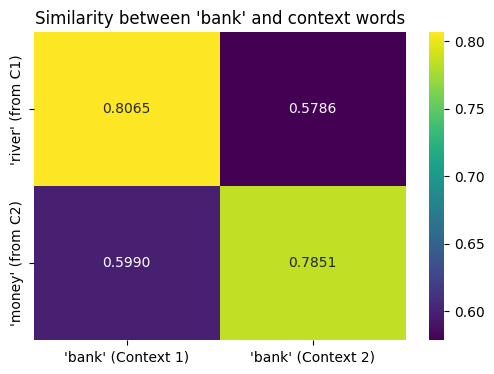

In [25]:
#@title 文脈ベクトルの比較
#@markdown ---
#@markdown ### フォーム
#@markdown 比較したい2つの文と、その文に含まれる「共通の単語」を指定してください。
text_context1 = "I sat on the river bank." #@param {type:"string"}
text_context2 = "I went to the bank to deposit money." #@param {type:"string"}
common_word_context = "bank" #@param {type:"string"}
#@markdown ---
#@markdown 比較したい文脈語（文1から）
context_word1 = "river" #@param {type:"string"}
#@markdown 比較したい文脈語（文2から）
context_word2 = "money" #@param {type:"string"}
#@markdown ---

from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. トークナイズ ---
inputs_context1 = tokenizer(text_context1, return_tensors="pt").to(device)
inputs_context2 = tokenizer(text_context2, return_tensors="pt").to(device)

# --- 2. モデル全体に入力 ---
with torch.no_grad():
    outputs_context1 = model(**inputs_context1)
    outputs_context2 = model(**inputs_context2)

contextual_embeddings1 = outputs_context1.last_hidden_state
contextual_embeddings2 = outputs_context2.last_hidden_state

# --- 3. IDを取得 ---
try:
    common_token_id = tokenizer.convert_tokens_to_ids(common_word_context.lower())
    context1_token_id = tokenizer.convert_tokens_to_ids(context_word1.lower())
    context2_token_id = tokenizer.convert_tokens_to_ids(context_word2.lower())

    # --- 4. ベクトルを抽出 ---
    common_index1 = (inputs_context1['input_ids'][0] == common_token_id).nonzero(as_tuple=True)[0][0]
    common_index2 = (inputs_context2['input_ids'][0] == common_token_id).nonzero(as_tuple=True)[0][0]

    context1_index = (inputs_context1['input_ids'][0] == context1_token_id).nonzero(as_tuple=True)[0][0]
    context2_index = (inputs_context2['input_ids'][0] == context2_token_id).nonzero(as_tuple=True)[0][0]

    common_vec1_context = contextual_embeddings1[0, common_index1].cpu().numpy()
    common_vec2_context = contextual_embeddings2[0, common_index2].cpu().numpy()

    context1_vec = contextual_embeddings1[0, context1_index].cpu().numpy()
    context2_vec = contextual_embeddings2[0, context2_index].cpu().numpy()

    # --- 5. 比較 (コサイン類似度) ---
    similarity_common = cosine_similarity([common_vec1_context], [common_vec2_context])
    print(f"\n--- 文脈ベクトルの比較 ({common_word_context} vs {common_word_context}) ---")
    print(f"文1の'{common_word_context}' と 文2の'{common_word_context}' のコサイン類似度: {similarity_common[0][0]:.4f}")
    if similarity_common[0][0] < 0.7:
        print("➡️ 成功: 類似度が低く、意味が区別されています。")
    else:
        print("➡️ 注意: 類似度があまり下がりませんでした。")


    # --- 6. (おまけ) 文脈との類似度 ---
    sim1_v_context1 = cosine_similarity([common_vec1_context], [context1_vec])[0][0]
    sim1_v_context2 = cosine_similarity([common_vec1_context], [context2_vec])[0][0]
    sim2_v_context1 = cosine_similarity([common_vec2_context], [context1_vec])[0][0]
    sim2_v_context2 = cosine_similarity([common_vec2_context], [context2_vec])[0][0]

    print("\n--- (おまけ) 文脈との類似度 ---")

    # 可視化 (英語)
    df = pd.DataFrame({
        f"'{common_word_context}' (Context 1)": [sim1_v_context1, sim1_v_context2],
        f"'{common_word_context}' (Context 2)": [sim2_v_context1, sim2_v_context2]
    }, index=[f"'{context_word1}' (from C1)", f"'{context_word2}' (from C2)"])

    plt.figure(figsize=(6, 4))
    sns.heatmap(df, annot=True, cmap="viridis", fmt=".4f")
    plt.title(f"Similarity between '{common_word_context}' and context words")
    plt.show()

except IndexError:
    print(f"\nエラー: フォームに入力された単語が、指定された文に含まれているか確認してください。")
except Exception as e:
    print(f"\nエラーが発生しました: {e}")

> 👩‍🎓 **課題 (ステップ2)**
>
> 1.  上のセルのフォーム機能を使って、ステップ1で試した多義語（例: `bat`）の文を入力してみましょう。
> 2.  ステップ1では類似度が高かった（差がほぼ0だった）のに対し、ステップ2（Attention通過後）では類似度が低くなる（例: 0.7未満）ことを確認してください。
> 3.  （考察）なぜAttentionを通すと、同じ単語でも文脈によってベクトルが変わるのか、ステップ2の解説を読んで自分の言葉で説明してください。（自由記述）

# ✍️ ステップ3: 次の単語を予測する (Generation)

ステップ2では、BERT（の軽量版）が文脈を読んで単語の意味を理解する仕組み（穴埋め問題が得意）を見ました。BERTは文の**両側**（左と右）を見て文脈を判断します。

一方、**GPT** は、ご指摘の通り「**そこまでの文章の意味を集約**」し、「**次の単語**」を予測することに特化しています。左から右へ、一方通行で処理します。

GPTが次の単語を予測するプロセスは、以下の通りです。

1.  入力された文（例: "My hobby is"）をトークンに区切ります。
2.  各トークンを「埋め込みベクトル」にします（ステップ1）。
3.  Attention（GPTの場合は、自分より左側の単語にしか注目できない仕組み）を使って、各トークンを「文脈ベクトル」に変換します（ステップ2）。
4.  **重要:** 文の**一番最後**のトークン（この例では `is`）の「文脈ベクトル」を取り出します。このベクトルが、「"My hobby is" まで読んだ時点での文脈の集約」です。
5.  ご指摘の通り、この集約された文脈ベクトル（例: 768次元）を、ある特別な「**全結合層（Linear Layer）**」に入力します。
6.  この全結合層は、**LM Head (Language Model Head)** と呼ばれ、その出力の次元数は、モデルが知っている**辞書の総単語数**（例: 50257次元）になっています。
7.  出力された50257個の数値（**ロジット**と呼ばれます）を、**Softmax** という関数に通すことで、合計が1.0になる「確率」に変換します。
8.  これが、「"My hobby is" の次にくる単語の確率分布」です。
9.  確率が最も高い単語（例: `reading`）を選んだり、確率に基づいてランダムに選んだり（サンプリング）することで、文章が生成されます。

実際に `GPT-2`（GPTの初期の公開モデル）を使って、次の単語の確率が計算される様子を見てみましょう。

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT-2 Model and Tokenizer loaded.
入力文: 'My hobby is'
  -> トークン: ['My', ' hobby', ' is']

--- 「My hobby is」の次にくる単語の予測 (Top 10) ---
Predicted Word  Probability (%)
            to        21.815641
           the         2.808940
             a         2.196267
        making         1.585573
           not         1.497221
       playing         1.185638
       writing         1.003004
   photography         0.968170
            in         0.954586
            my         0.933391


<Figure size 1000x500 with 0 Axes>

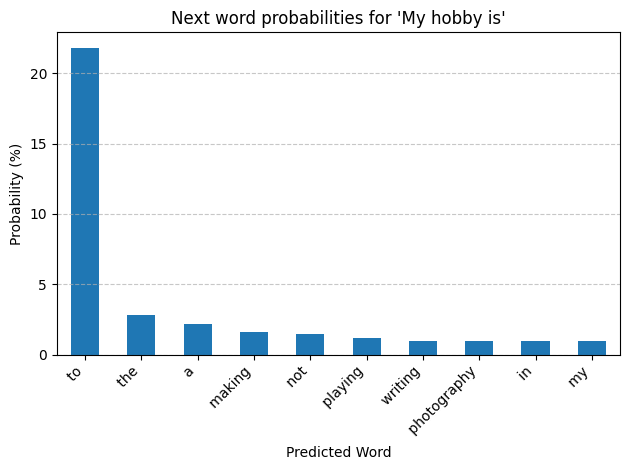


➡️ GPTは ' to' が次に来る確率が最も高いと予測しました！


In [29]:
#@title 次単語予測の確率分布
#@markdown ---
#@markdown ### フォーム
#@markdown 次の単語を予測させたい「入力文（プロンプト）」を指定してください。
prompt_text = "My hobby is" #@param {type:"string"}
#@markdown 表示したい予測候補の数
top_k_value = 10 #@param {type:"slider", min:1, max:20, step:1}
#@markdown ---

from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

# GPT-2 のモデルとトークナイザがロード済みか確認
if 'model_gpt' not in globals():
    model_name_gpt = "gpt2"
    tokenizer_gpt = GPT2Tokenizer.from_pretrained(model_name_gpt)
    model_gpt = GPT2LMHeadModel.from_pretrained(model_name_gpt).to(device)
    if tokenizer_gpt.pad_token is None:
        tokenizer_gpt.pad_token = tokenizer_gpt.eos_token
        model_gpt.config.pad_token_id = model_gpt.config.eos_token_id
    print("GPT-2 Model and Tokenizer loaded.")

# --- 1. トークナイズ ---
inputs_gpt = tokenizer_gpt(prompt_text, return_tensors="pt").to(device)
input_ids = inputs_gpt['input_ids']

print(f"入力文: '{prompt_text}'")

# 'Ġ' が表示されないように修正
token_ids_list = input_ids[0].tolist()
tokens_display = [tokenizer_gpt.decode([token_id]) for token_id in token_ids_list]
print(f"  -> トークン: {tokens_display}")


# --- 2. モデルに入力 ---
with torch.no_grad():
    outputs_gpt = model_gpt(**inputs_gpt)

# --- 3. ロジットの取得 ---
logits = outputs_gpt.logits
if logits.shape[1] == 0: # 入力が空の場合
     print("エラー: 入力が空です。")
else:
    # --- 4. 「最後のトークン」のロジットを取得 ---
    last_token_logits = logits[0, -1, :]

    # --- 5. Softmax で確率に変換 ---
    probabilities = F.softmax(last_token_logits, dim=-1)

    # --- 6. 確率が高い単語を表示 ---
    top_k_probs, top_k_indices = torch.topk(probabilities, top_k_value)

    print(f"\n--- 「{prompt_text}」の次にくる単語の予測 (Top {top_k_value}) ---")

    results = []
    for i in range(top_k_value):
        token_id = top_k_indices[i].item()
        token_str = tokenizer_gpt.decode(token_id)
        prob = top_k_probs[i].item()
        results.append((token_str, prob * 100))

    df_probs = pd.DataFrame(results, columns=["Predicted Word", "Probability (%)"])
    print(df_probs.to_string(index=False))

    # --- 7. 可視化 (英語) ---
    plt.figure(figsize=(10, 5))
    df_probs.set_index("Predicted Word").plot(kind='bar', legend=False)
    plt.title(f"Next word probabilities for '{prompt_text}'")
    plt.ylabel("Probability (%)")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7) # ← 修正後

    plt.tight_layout()
    plt.show()

    # --- 8. 動的な結果の表示 ---
    top_word = df_probs.iloc[0]["Predicted Word"]
    print(f"\n➡️ GPTは '{top_word}' が次に来る確率が最も高いと予測しました！")

> 👩‍🎓 **課題 (ステップ3)**
>
> 1.  上のセルのフォーム機能を使って、`prompt_text` に様々な（英語の）文章を入力してみましょう。
> 2.  （例: "The capital of Japan is", "My hobby is", "I like to eat" など）
> 3.  GPTが予測する「次の単語」は、文脈として妥当でしょうか？ `top_k_value` を変えると、予測候補はどのように変わるか観察してください。
> 4.  （考察）GPTは、なぜ「そこまでの文脈」だけで次の単語を予測できるのでしょうか？ ステップ3の解説（特にLM Head）を読んで、自分の言葉で説明してください。（自由記述）

---
# 振り返り課題（穴埋め）

ここまでのステップで学んだことを、以下の穴埋め問題で振り返りましょう。

（ `...` の部分に当てはまる適切な語句を考えてください）

1.  コンピュータは単語をそのまま扱えないため、「`...`」(Embedding) という、単語を数値のリスト（ベクトル）に変換する層を使います。
2.  ステップ1の段階では、`bank` のような多義語も、文脈に関わらず `...` (同じ/異なる) ベクトルで表現されます。
3.  ステップ2では、`...` (Attention) 機構が、文中の他の単語に「注目」し、元のベクトルを文脈に応じた「文脈ベクトル」に変換しました。
4.  ステップ3のGPTは、文の `...` (最初/最後) のトークンの文脈ベクトルを、「そこまでの文脈の集約」として利用します。
5.  この集約されたベクトルを、出力次元が辞書の総単語数になっている `...` (LM Head / 埋め込み層) と呼ばれる全結合層に入力します。
6.  最後に `...` (Softmax) 関数を使って、辞書の全単語が「次にくる確率」を計算し、テキストを生成します。

---
## 🚀 課題: BERT と GPT の違い

私たちはステップ2・3で `BERT`（の軽量版）を、ステップ3で `GPT` を使いました。どちらも同じ「Transformer」という技術をベースにしていますが、目的が大きく異なります。

### 1. 目的の違い（穴埋め）

以下の説明を読み、`...` に（BERT / GPT）のどちらが入るか考えてみましょう。

* **`...` (BERT)** は、文の**両側**（左右）の文脈を読んで、文中の単語の意味を深く理解するのが得意です。主なタスクは「穴埋め問題（Masked Language Model）」や「文章分類」です。
* **`...` (GPT)** は、文の**左側**（そこまで）の文脈だけを読んで、**次**に来る単語を予測するのが得意です。主なタスクは「文章生成（Generative）」です。

### 2. 「文脈ベクトル」の意味の違い

この目的の違いは、「文脈ベクトル」が何を表しているかに現れます。

* **BERTの文脈ベクトル:**
    * `bank` のベクトルは、その単語「自体」が文脈（"river" や "money"）の中で持つ意味（土手/銀行）を強く表現します。穴埋めに使うため、その単語の意味特定が重要です。
* **GPTの文脈ベクトル:**
    * `bank` のベクトルも文脈（"river"）を読み込みますが、その目的は「`bank` **の次**にくる単語」を予測するための「途中経過」です。
    * GPTが最も重要視するのは、**最後のトークン**のベクトルです。これが「そこまでの全情報の集約」となり、次の単語予測に使われます。

ご指摘の通り、GPTにとって「`bank` が小川か銀行か」の区別は、**次の単語を予測するのに必要な分だけ**行われます。BERTほどその単語自体の意味を突き詰める必要はありません。

### 3. 実践: BERTとGPTの「最後のベクトル」の比較

同じ文をBERTとGPTに入力し、**最後のトークン**（`bank`）のベクトルが、それぞれどの単語と一番似ているか（近いか）を比較してみましょう。

* BERT（`DistilBERT`）は `bank` の意味（`river` に近い）を強く反映するはずです。
* GPT（`GPT-2`）は `bank` の意味も持ちつつ、「次」の予測のための情報を集約しているはずです。

In [ ]:
#@title 🧑‍🎓 BERT vs GPT ベクトル比較

#@markdown ---
#@markdown ### フォーム
#@markdown 比較したい共通の文（最後が多義語だと分かりやすい）
common_text = "I sat on the river bank" #@param {type:"string"}
#@markdown ---

# --- 1. BERT (DistilBERT) でベクトル取得 ---
print("--- 1. BERT (DistilBERT) ---")
inputs_bert = tokenizer(common_text, return_tensors="pt").to(device)
tokens_bert = tokenizer.convert_ids_to_tokens(inputs_bert['input_ids'][0])
print(f"BERT トークン: {tokens_bert}")

with torch.no_grad():
    outputs_bert = model(**inputs_bert)

# BERTの最後のトークン ("bank") のベクトル
# [CLS] トークンが先頭に、[SEP] トークンが末尾に追加されるため、
# 文の最後の単語 'bank' は、リストの最後から2番目 (-2) になります。
last_token_index_bert = -2
bert_last_vec = outputs_bert.last_hidden_state[0, last_token_index_bert, :].cpu().numpy()

# BERTの "river" のベクトル
river_token_id = tokenizer.convert_tokens_to_ids("river")
river_index_bert_list = (inputs_bert['input_ids'][0] == river_token_id).nonzero(as_tuple=True)[0]
if len(river_index_bert_list) == 0:
    print("エラー: BERTトークナイザで 'river' が見つかりません。")
    bert_river_vec = None
else:
    river_index_bert = river_index_bert_list[0]
    bert_river_vec = outputs_bert.last_hidden_state[0, river_index_bert, :].cpu().numpy()


# --- 2. GPT-2 でベクトル取得 ---
print("\n--- 2. GPT-2 ---")
inputs_gpt = tokenizer_gpt(common_text, return_tensors="pt").to(device)

# ▼▼▼ 'Ġ' が表示されないように修正 ▼▼▼
token_ids_gpt_list = inputs_gpt['input_ids'][0].tolist()
tokens_gpt_display = [tokenizer_gpt.decode([token_id]) for token_id in token_ids_gpt_list]
print(f"GPT トークン: {tokens_gpt_display}")
# ▲▲▲ 修正ここまで ▲▲▲

with torch.no_grad():
    # GPTは .last_hidden_state を直接返さないので、.transformer(...) から取得
    gpt_hidden_states = model_gpt.transformer(**inputs_gpt).last_hidden_state

# GPTの最後のトークン ("bank") のベクトル
# (GPT-2は [CLS] や [SEP] を自動で追加しないため、文の最後がリストの最後です)
last_token_index_gpt = -1 # 穴埋め: -1
gpt_last_vec = gpt_hidden_states[0, last_token_index_gpt, :].cpu().numpy()

# GPTの "river" のベクトル
# (GPTのトークナイザは 'Ġriver' のように空白を記号で扱う)
# 'Ġriver' (スペース付き) を優先的に探す
river_token_id_gpt = tokenizer_gpt.convert_tokens_to_ids("Ġriver")
if river_token_id_gpt == tokenizer_gpt.unk_token_id:
    # 見つからなければ 'river' (スペースなし) を探す
    river_token_id_gpt = tokenizer_gpt.convert_tokens_to_ids("river")

river_index_gpt_list = (inputs_gpt['input_ids'][0] == river_token_id_gpt).nonzero(as_tuple=True)[0]
if len(river_index_gpt_list) == 0:
    print("エラー: GPT-2トークナイザで 'river' (または 'Ġriver') が見つかりません。")
    gpt_river_vec = None
else:
    river_index_gpt = river_index_gpt_list[0]
    gpt_river_vec = gpt_hidden_states[0, river_index_gpt, :].cpu().numpy()


# --- 3. 類似度の比較 ---
# 両方のベクトルが正常に取得できた場合のみ実行
if bert_river_vec is not None and gpt_river_vec is not None:
    print("\n--- 3. 類似度比較 ---")

    # BERT: "bank" と "river" の類似度
    sim_bert = cosine_similarity([bert_last_vec], [bert_river_vec]) # 穴埋め: [bert_last_vec], [bert_river_vec]
    print(f"BERT: 最後の 'bank' と 'river' の類似度: {sim_bert[0][0]:.4f}")

    # GPT: "bank" と "river" の類似度
    sim_gpt = cosine_similarity([gpt_last_vec], [gpt_river_vec]) # 穴埋め: [gpt_last_vec], [gpt_river_vec]
    print(f"GPT: 最後の 'bank' と 'river' の類似度: {sim_gpt[0][0]:.4f}")

    print("\n(注: GPT-2は 'river' を ' river' とトークナイズすることがあり、BERTと条件が完全には一致しませんが、傾向を比較します)")
else:
    print(f"\n--- 3. 類似度比較 (スキップ) ---")
    print("文脈語 ('river') が見つからなかったため、類似度比較をスキップしました。")

> 👩‍🎓 **課題 (BERT vs GPT 考察)**
>
> 1.  BERTとGPTで、最後の単語（`bank`）と文脈語（`river`）の類似度にどのような違いが出たでしょうか？
> 2.  （考察）ステップ3で学んだように、GPTはこの「最後のベクトル」を使って**次の単語**を予測します。なぜ、`bank` 自体の意味（`river` に近いかどうか）を突き詰めるよりも、「そこまでの文脈を集約したベクトル」を使う方が、次の単語（例: "and", "is", "was" など）を予測するのに適していると考えられるか、あなたの考えを説明してください。（自由記述）

# 🎉 まとめ

お疲れ様でした！この課題では、GPTのような大規模言語モデルがテキストを生成する3つの基本的なステップを学びました。

1.  **📝 埋め込み (Embedding):**
    単語を「意味を持つ数値ベクトル」に変換します。この時点では、まだ文脈（多義語）は考慮されていません。

2.  **💡 文脈化 (Contextualization):**
    **Attention** という仕組みが、文中の他の単語に「注目」し、元の埋め込みベクトルを「文脈ベクトル」にアップグレードします。これにより `bank` のような多義語も区別できるようになりました。

3.  **✍️ 生成 (Generation):**
    GPTは、**最後の単語の文脈ベクトル**（＝そこまでの文脈の集約）を **LM Head（全結合層）** に通します。これにより、辞書にある全単語の「次の単語としての確率」が計算され、最も確率の高い単語が選ばれます。

今回は、Attention がどのように重みを計算しているか？（Self-Attention や QKV）という核心部分には触れませんでしたが、入力（埋め込み）と出力（文脈ベクトル、確率）がどう変わるかを見ることで、GPT によるテキスト生成の全体像を掴んでいただけたかと思います。